In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))
suppressMessages(library(parallel))
suppressMessages(library(ggrepel))

In [2]:
set.seed(42)
getwd()

addArchRThreads(threads = parallel::detectCores() - 2)
addArchRGenome("hg38")

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Fibroblast/code"

Setting default number of Parallel threads to 126.

Setting default genome to Hg38.



In [3]:
## subset atac project
proj <- loadArchRProject("../data/snATAC_SCARA5_Myofib", showLogo = FALSE)

Successfully loaded ArchRProject!



In [4]:
## define functions
library(Rcpp)
Rcpp::sourceCpp(code='
  #include <Rcpp.h>

  using namespace Rcpp;
  using namespace std;

  // Adapted from https://github.com/AEBilgrau/correlateR/blob/master/src/auxiliary_functions.cpp
  // [[Rcpp::export]]
  Rcpp::NumericVector rowCorCpp(IntegerVector idxX, IntegerVector idxY, Rcpp::NumericMatrix X, Rcpp::NumericMatrix Y) {
    
    if(X.ncol() != Y.ncol()){
      stop("Columns of Matrix X and Y must be equal length!");
    }

    if(max(idxX)-1 > X.nrow()){
      stop("Idx X greater than nrow of Matrix X");
    }

    if(max(idxY)-1 > Y.nrow()){
      stop("Idx Y greater than nrow of Matrix Y");
    }

    // Transpose Matrices
    X = transpose(X);
    Y = transpose(Y);
    
    const int nx = X.ncol();
    const int ny = Y.ncol();

    // Centering the matrices
    for (int j = 0; j < nx; ++j) {
      X(Rcpp::_, j) = X(Rcpp::_, j) - Rcpp::mean(X(Rcpp::_, j));
    }

    for (int j = 0; j < ny; ++j) {
      Y(Rcpp::_, j) = Y(Rcpp::_, j) - Rcpp::mean(Y(Rcpp::_, j));
    }

    // Compute 1 over the sample standard deviation
    Rcpp::NumericVector inv_sqrt_ss_X(nx);
    for (int i = 0; i < nx; ++i) {
      inv_sqrt_ss_X(i) = 1/sqrt(Rcpp::sum( X(Rcpp::_, i) * X(Rcpp::_, i) ));
    }

    Rcpp::NumericVector inv_sqrt_ss_Y(ny);
    for (int i = 0; i < ny; ++i) {
      inv_sqrt_ss_Y(i) = 1/sqrt(Rcpp::sum( Y(Rcpp::_, i) * Y(Rcpp::_, i) ));
    }

    //Calculate Correlations
    const int n = idxX.size();
    Rcpp::NumericVector cor(n);
    for(int k = 0; k < n; k++){
      cor[k] = Rcpp::sum( X(Rcpp::_, idxX[k] - 1) * Y(Rcpp::_, idxY[k] - 1) ) * inv_sqrt_ss_X(idxX[k] - 1) * inv_sqrt_ss_Y(idxY[k] - 1);    } 

    return(cor);

  }'
)


Rcpp::sourceCpp(code='
  #include <Rcpp.h>
using namespace Rcpp;
using namespace std;

// [[Rcpp::export]]
Rcpp::IntegerVector determineOverlapCpp(IntegerMatrix m, int overlapCut){

  int k2 = 2 * m.ncol();
  int nr = m.nrow();
  int nUnion;
  int maxOverlap;
  IntegerVector unionVector;
  IntegerVector testVector = IntegerVector(nr);
  IntegerVector nOverlap = IntegerVector(nr);
  NumericVector maxOverlapVector = NumericVector(nr);
  IntegerVector vi;
  IntegerVector vj;

  for (int i = 1; i < nr; i++){
   
    if (i % 500 == 0) Rcpp::Rcout << "Completed Computing KNN Overlap " << i << " of " << nr << endl;
    
    for(int j = 0; j < i; j++){
      
      if(testVector(j) == 0){
        vi = m(i, _);
        vj = m(j, _);
        unionVector = union_( vi , vj );
        nUnion = unionVector.size();
        nOverlap(j) = k2 - nUnion;
      }else{
        nOverlap(j) = 0;
      }
    }

    maxOverlap = max( nOverlap );
    maxOverlapVector(i) = maxOverlap;
    if(maxOverlap > overlapCut){
      testVector(i) = -1;
    }

  }

  return testVector;

}'
)

Creating Trajectory Group Matrix..

Smoothing...

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b520300802-Date-2022-01-06_Time-11-54-58.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b520300802-Date-2022-01-06_Time-11-54-58.log



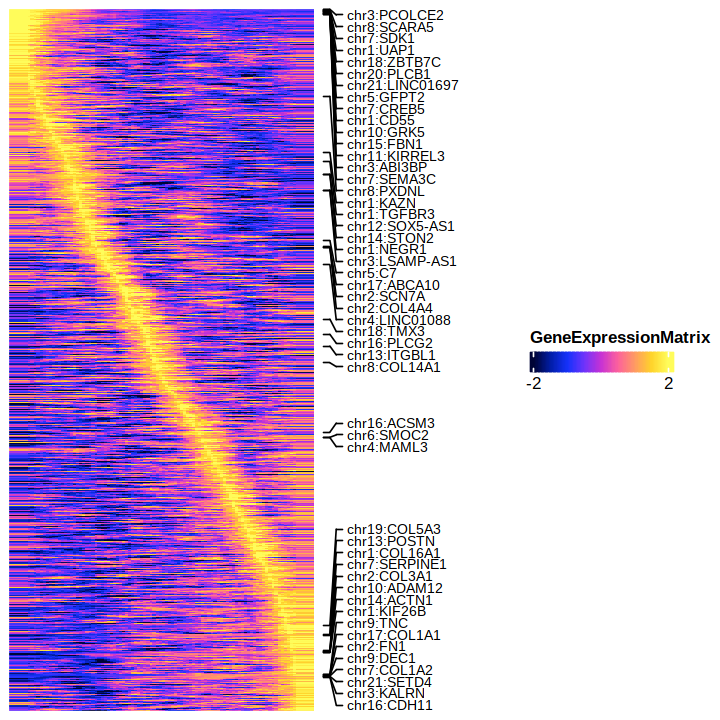

In [31]:
## create aggregated gene matrix
trajGEX <- getTrajectory(ArchRProj = proj,
                         name = "SCARA5_Myofib_dm",
                         useMatrix = "GeneExpressionMatrix",
                         log2Norm = TRUE,
                        smoothWindow = 11)

ht <- plotTrajectoryHeatmap(trajGEX,
                        varCutOff = 0.9,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2))

options(repr.plot.height = 6, repr.plot.width = 6)

ht

In [6]:
geneMatrix <- getMatrixFromProject(proj, useMatrix = "GeneExpressionMatrix")

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-d91b578851270-Date-2022-01-06_Time-11-50-58.log
If there is an issue, please report to github with logFile!

2022-01-06 11:51:01 : Organizing colData, 0.046 mins elapsed.

2022-01-06 11:51:02 : Organizing rowData, 0.054 mins elapsed.

2022-01-06 11:51:02 : Organizing rowRanges, 0.055 mins elapsed.

2022-01-06 11:51:02 : Organizing Assays (1 of 1), 0.055 mins elapsed.

2022-01-06 11:51:02 : Constructing SummarizedExperiment, 0.065 mins elapsed.

2022-01-06 11:51:03 : Finished Matrix Creation, 0.081 mins elapsed.



In [7]:
groupMatRNA <- plotTrajectoryHeatmap(trajGEX,
                        varCutOff = 0.9,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2),
                           returnMatrix = TRUE)
geneSet <- geneMatrix@elementMetadata

rownames(geneSet) <- paste0(geneSet$seqnames, ":", geneSet$name)

geneSet <- geneSet[rownames(groupMatRNA), ]

geneStart <- GRanges(geneSet$seqnames, 
                   IRanges(geneSet$start, 
                           width = 1), 
                     name = geneSet$name, 
        idx = geneSet$idx)

seRNA <- SummarizedExperiment(assays = SimpleList(RNA = groupMatRNA), 
                              rowRanges = geneStart)

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b52d12095-Date-2022-01-06_Time-11-51-03.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b52d12095-Date-2022-01-06_Time-11-51-03.log



In [8]:
seRNA

class: RangedSummarizedExperiment 
dim: 1902 100 
metadata(0):
assays(1): RNA
rownames(1902): chr3:PCOLCE2 chr8:SCARA5 ... chr3:ATP13A3 chr1:ZMYM4
rowData names(2): name idx
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

In [9]:
## create aggregated gene matrix
trajPM <- getTrajectory(ArchRProj = proj,
                         name = "SCARA5_Myofib_dm",
                         useMatrix = "PeakMatrix",
                         log2Norm = TRUE,
                        smoothWindow = 11)

trajPM

Creating Trajectory Group Matrix..

Smoothing...



class: SummarizedExperiment 
dim: 189676 100 
metadata(1): Params
assays(2): smoothMat mat
rownames(189676): chr1:817103_817603 chr1:817955_818455 ...
  chrX:155874546_155875046 chrX:155881037_155881537
rowData names(4): seqnames idx start end
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

In [10]:
groupMatATAC <- plotTrajectoryHeatmap(trajPM,
                        varCutOff = 0,
                                      maxFeatures = 189676,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2),
                           returnMatrix = TRUE
                          )

nrow(groupMatATAC)
head(groupMatATAC)

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b53db193f5-Date-2022-01-06_Time-11-51-29.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b53db193f5-Date-2022-01-06_Time-11-51-29.log



[1] 189676

,T.0_1,T.1_2,T.2_3,T.3_4,T.4_5,T.5_6,T.6_7,T.7_8,T.8_9,T.9_10,⋯,T.90_91,T.91_92,T.92_93,T.93_94,T.94_95,T.95_96,T.96_97,T.97_98,T.98_99,T.99_100
chr5:180370685_180371185,1.952773,1.952773,1.952773,1.952773,1.952773,1.952773,1.891641,1.580525,1.755830,1.797092,⋯,-0.4516060,-0.3564308,-0.4024781,-0.4637168,-0.4179661,-0.4179661,-0.4179661,-0.4179661,-0.4179661,-0.4179661
chr6:43717898_43718398,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.933850,1.850961,1.882950,⋯,-0.5971435,-0.5946779,-0.6694062,-0.7565277,-0.7305377,-0.7305377,-0.7305377,-0.7305377,-0.7305377,-0.7305377
chr22:27726596_27727096,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.722426,1.662516,1.376434,⋯,-0.5053733,-0.5342790,-0.4312217,-0.6204278,-0.5690002,-0.5690002,-0.5690002,-0.5690002,-0.5690002,-0.5690002
chr16:17331039_17331539,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.915107,2.000000,1.737331,1.854680,⋯,-0.2594213,-0.3410438,-0.6639266,-0.7745156,-0.7721244,-0.7721244,-0.7721244,-0.7721244,-0.7721244,-0.7721244
chr2:219498498_219498998,1.990211,1.990211,1.990211,1.990211,1.990211,1.990211,1.817884,1.630946,1.584753,1.536889,⋯,-0.5291561,-0.6806500,-0.7433244,-0.6687891,-0.5582491,-0.5582491,-0.5582491,-0.5582491,-0.5582491,-0.5582491
chr7:28847568_28848068,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,⋯,-1.3492738,-1.3216857,-1.2249007,-1.2354899,-1.1245295,-1.1245295,-1.1245295,-1.1245295,-1.1245295,-1.1245295


In [11]:
df_peak <- stringr::str_split_fixed(rownames(groupMatATAC), ":|-|_", 3)
head(df_peak)

peakSet <- GRanges(df_peak[, 1], IRanges(start = as.numeric(df_peak[, 2]),
                                           end = as.numeric(df_peak[, 3])))

seATAC <- SummarizedExperiment(assays = SimpleList(ATAC = groupMatATAC),
                               rowRanges = peakSet)

chr5,180370685,180371185
chr6,43717898,43718398
chr22,27726596,27727096
chr16,17331039,17331539
chr2,219498498,219498998
chr7,28847568,28848068


In [12]:
seATAC

class: RangedSummarizedExperiment 
dim: 189676 100 
metadata(0):
assays(1): ATAC
rownames(189676): chr5:180370685_180371185 chr6:43717898_43718398 ...
  chr14:91187631_91188131 chr5:174530981_174531481
rowData names(0):
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

In [13]:
## find putative peak-to-gene
maxDist = 250000

o <- DataFrame(findOverlaps(resize(seRNA, 2 * maxDist + 1, "center"),
                            resize(rowRanges(seATAC), 1, "center"),
                            ignore.strand = TRUE))

o$distance <- distance(rowRanges(seRNA)[o[, 1]], 
                       rowRanges(seATAC)[o[, 2]])
colnames(o) <- c("B", "A", "distance")

df <- rowRanges(seATAC)[o$A, ]

o$gene <- rowData(seRNA)[o$B, ]$name
o$peak <- paste0(df@seqnames, "_",
                 as.data.frame(df@ranges)$start, "_",
                 as.data.frame(df@ranges)$end)

In [14]:
outATAC <- file.path(getOutputDirectory(proj), "Peak2GeneLinks", "seATAC-Group-KNN.rds")
outRNA <- file.path(getOutputDirectory(proj), "Peak2GeneLinks", "seRNA-Group-KNN.rds")

In [15]:
## compute correlation
o$Correlation <- rowCorCpp(as.integer(o$A), 
                           as.integer(o$B), 
                           assay(seATAC), 
                           assay(seRNA))

o$VarAssayA <- ArchR:::.getQuantiles(matrixStats::rowVars(assay(seATAC)))[o$A]
o$VarAssayB <- ArchR:::.getQuantiles(matrixStats::rowVars(assay(seRNA)))[o$B]
o$TStat <- (o$Correlation / sqrt((pmax(1-o$Correlation^2, 0.00000000000000001, na.rm = TRUE))/(ncol(seATAC)-2))) #T-statistic P-value

o$Pval <- 2 * pt(-abs(o$TStat), ncol(seATAC) - 2)
o$FDR <- p.adjust(o$Pval, method = "fdr")
out <- o[, c("A", "B", "Correlation", "FDR", "VarAssayA", 
        "VarAssayB", "distance")]
colnames(out) <- c("idxATAC", "idxRNA", "Correlation", "FDR", 
        "VarQATAC", "VarQRNA", "Distance")
mcols(peakSet) <- NULL
names(peakSet) <- NULL
metadata(out)$peakSet <- peakSet
metadata(out)$geneSet <- geneStart

out$gene <- o$gene
out$peak <- o$peak
  
out <- out[!is.na(out$FDR), ]

metadata(out)$seATAC <- outATAC
metadata(out)$seRNA <- outRNA

metadata(proj@peakSet)$Peak2GeneLinks <- out

In [16]:
head(out)

DataFrame with 6 rows and 9 columns
    idxATAC    idxRNA Correlation         FDR    VarQATAC   VarQRNA  Distance
  <integer> <integer>   <numeric>   <numeric>   <numeric> <numeric> <integer>
1        29         1    0.916624 9.36291e-37 0.026682343   0.14511     21055
2      6232         1    0.372232 4.85835e-04 0.509115544   0.14511     73903
3      7433         1    0.636633 2.78837e-11 0.374217086   0.14511     46777
4      7670         1    0.683648 2.10567e-13 0.000664291   0.14511     46788
5      8635         1    0.611443 2.76582e-10 0.150799258   0.14511     25157
6     10121         1    0.880951 4.49864e-30 0.772111390   0.14511      5653
     gene                   peak
  <array>            <character>
1 PCOLCE2 chr3_142910259_14291..
2 PCOLCE2 chr3_142963107_14296..
3 PCOLCE2 chr3_142935981_14293..
4 PCOLCE2 chr3_142841914_14284..
5 PCOLCE2 chr3_142914361_14291..
6 PCOLCE2 chr3_142883049_14288..

In [17]:
saveRDS(seATAC, file = outATAC)
saveRDS(seRNA, file = outRNA)

In [18]:
df_p2g <- out %>%
    as.data.frame() %>%
    subset(Correlation > 0) %>%
    subset(Distance > 2000 & FDR < 1e-04)

In [19]:
length(unique(df_p2g$gene))

[1] 1785

In [20]:
## update gene name and peak name
df_peak <- stringr::str_split_fixed(df_p2g$peak, "_", 3)
df_p2g$peak_name <- paste0(df_peak[, 1], ":", df_peak[, 2], "_", df_peak[, 3])
df_p2g$gene_name <- paste0(df_peak[, 1], ":", df_p2g$gene)

In [21]:
head(df_p2g)

,idxATAC,idxRNA,Correlation,FDR,VarQATAC,VarQRNA,Distance,gene,peak,peak_name,gene_name
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
1,29,1,0.9166241,9.362913e-37,0.0266823425,0.1451104,21055,PCOLCE2,chr3_142910259_142910759,chr3:142910259_142910759,chr3:PCOLCE2
3,7433,1,0.6366334,2.788368e-11,0.3742170860,0.1451104,46777,PCOLCE2,chr3_142935981_142936481,chr3:142935981_142936481,chr3:PCOLCE2
4,7670,1,0.6836479,2.105665e-13,0.0006642907,0.1451104,46788,PCOLCE2,chr3_142841914_142842414,chr3:142841914_142842414,chr3:PCOLCE2
5,8635,1,0.6114432,2.765816e-10,0.1507992577,0.1451104,25157,PCOLCE2,chr3_142914361_142914861,chr3:142914361_142914861,chr3:PCOLCE2
6,10121,1,0.8809510,4.498638e-30,0.7721113899,0.1451104,5653,PCOLCE2,chr3_142883049_142883549,chr3:142883049_142883549,chr3:PCOLCE2
8,20316,1,0.6840125,2.018375e-13,0.2025612096,0.1451104,23517,PCOLCE2,chr3_142912721_142913221,chr3:142912721_142913221,chr3:PCOLCE2


In [22]:
trajPM2 <- trajPM[df_p2g$peak_name, ]
trajGEX2 <- trajGEX[df_p2g$gene_name, ]

In [23]:
trajPM2
trajGEX2

class: SummarizedExperiment 
dim: 16299 100 
metadata(1): Params
assays(2): smoothMat mat
rownames(16299): chr3:142910259_142910759 chr3:142935981_142936481 ...
  chr1:35448426_35448926 chr1:35047355_35047855
rowData names(4): seqnames idx start end
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

class: SummarizedExperiment 
dim: 16299 100 
metadata(1): Params
assays(2): smoothMat mat
rownames(16299): chr3:PCOLCE2 chr3:PCOLCE2 ... chr1:ZMYM4 chr1:ZMYM4
rowData names(6): seqnames idx ... name strand
colnames(100): T.0_1 T.1_2 ... T.98_99 T.99_100
colData names(0):

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b54600716e-Date-2022-01-06_Time-11-51-44.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b54600716e-Date-2022-01-06_Time-11-51-44.log

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b5584049b9-Date-2022-01-06_Time-11-51-45.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-d91b5584049b9-Date-2022-01-06_Time-11-51-45.log



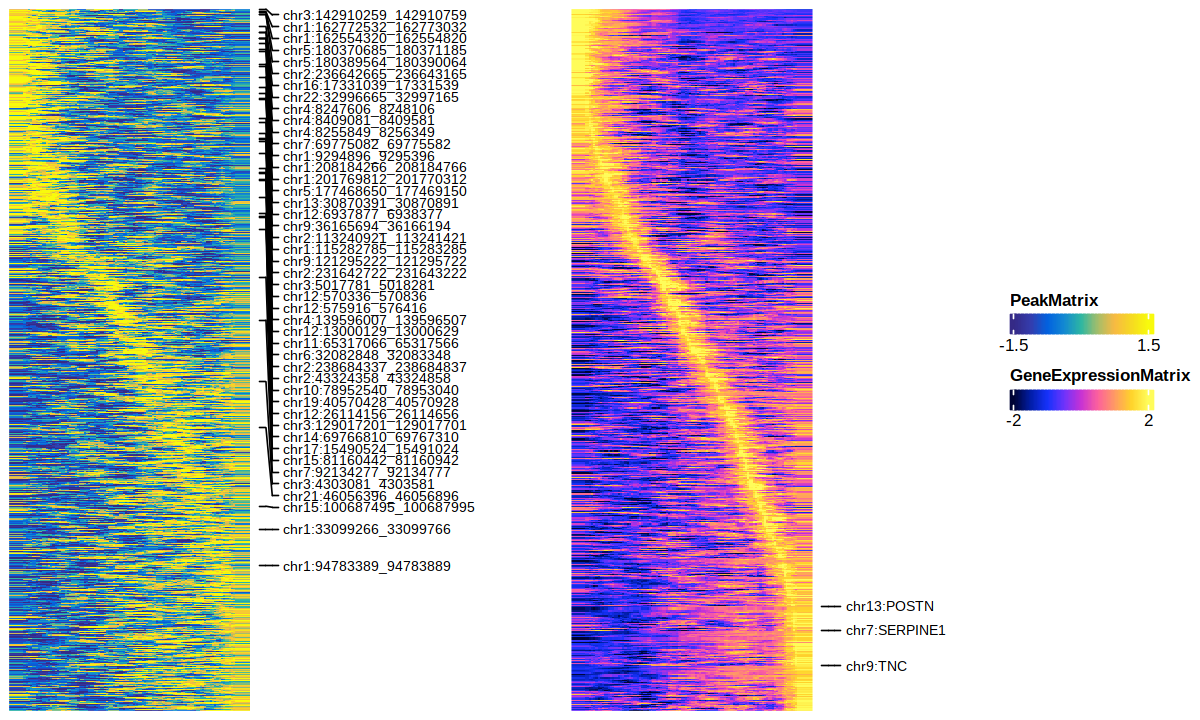

In [24]:
ht1 <- plotTrajectoryHeatmap(trajPM2, 
                            pal = paletteContinuous(set = "blueYellow"),
                            varCutOff = 0,
                            #limits = c(-2, 2),
                             maxFeatures = 100000,
                             rowOrder = 1:nrow(df_p2g))

ht2 <- plotTrajectoryHeatmap(trajGEX2, 
                            pal = paletteContinuous(set = "horizonExtra"),
                            varCutOff = 0,
                            limits = c(-2, 2),
                             maxFeatures = 100000,
                             rowOrder = 1:nrow(df_p2g))

options(repr.plot.height = 6, repr.plot.width = 10)

ht1 + ht2

In [25]:
write.csv(out, file = "../data/snATAC_SCARA5_Myofib/p2g_all.csv")
write.csv(df_p2g, file = "../data/snATAC_SCARA5_Myofib/p2g.csv")

In [26]:
saveArchRProject(ArchRProj = proj, 
                 load = FALSE)

Saving ArchRProject...



In [27]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 8

Matrix products: default
BLAS/LAPACK: /home/rs619065/miniconda3/envs/r-4.1/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] circlize_0.4.13             ComplexHeatmap_2.10.0      
 [3] ggrepel_0.9.1               phateR_1.0.7               
 [5] Ipaper_0.1.8                ggpubr_0.4.0               
 [7] Nebulosa_1.4.0              patchwork_1.1.1            
 [9] cowplot_1.1.1         